In [2]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

from numpy.random import seed
seed(123)


2024-06-05 18:17:42.412209: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-05 18:17:42.414635: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-05 18:17:42.453951: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 18:17:43.343067: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1


# Zad
Porównaj wyniki działań różnych optymalizacji


In [3]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()


/tmp/ipykernel_12152/1853370235.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_set = pd.read_csv('adult/adult.data', sep=", ",header = None)
/tmp/ipykernel_12152/1853370235.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_set = pd.read_csv('adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

/tmp/ipykernel_12152/2845591274.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})
/tmp/ipykernel_12152/2845591274.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['native_country'] = dataset['native_country'].replace(d)


(30162, 41)


(15060, 41)

# SGD

In [5]:
from keras.models import Sequential
from keras.layers import Dense

from keras.callbacks import History

history_sgd = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

/home/konrad/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │         4,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,771 (38.17 KB)

 Trainable params: 9,771 (38.17 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
sgd = tf.keras.optimizers.legacy.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy",optimizer=sgd, metrics=["accuracy"])

ImportError: `keras.optimizers.legacy` is not supported in Keras 3. When using `tf.keras`, to continue using a `tf.keras.optimizers.legacy` optimizer, you can install the `tf_keras` package (Keras 2) and set the environment variable `TF_USE_LEGACY_KERAS=True` to configure TensorFlow to use `tf_keras` when accessing `tf.keras`.

In [7]:
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[history_sgd])

Epoch 1/100
943/943 [==============================] - 2s 2ms/step - loss: 0.5303 - accuracy: 0.7499 - val_loss: 0.4117 - val_accuracy: 0.7985
Epoch 2/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3563 - accuracy: 0.8314 - val_loss: 0.3422 - val_accuracy: 0.8420
Epoch 3/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3378 - accuracy: 0.8413 - val_loss: 0.3348 - val_accuracy: 0.8441
Epoch 4/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3323 - accuracy: 0.8441 - val_loss: 0.3311 - val_accuracy: 0.8458
Epoch 5/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3297 - accuracy: 0.8453 - val_loss: 0.3296 - val_accuracy: 0.8472
Epoch 6/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3276 - accuracy: 0.8460 - val_loss: 0.3307 - val_accuracy: 0.8468
Epoch 7/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3268 - accuracy: 0.8475 - val_loss: 0.3280 - val_accuracy: 0.8461

In [8]:
history_sgd.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

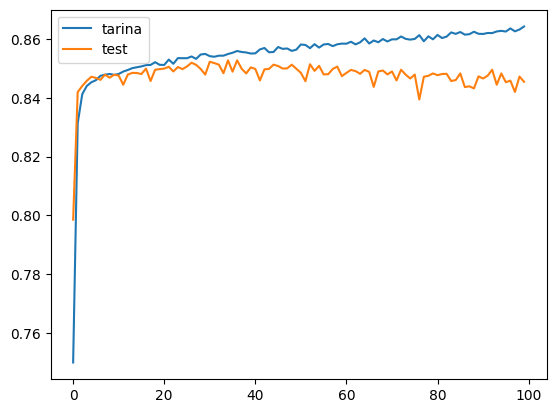

In [9]:
import matplotlib.pyplot as pl
plt.plot(history_sgd.history['accuracy'], label = "tarina")
plt.plot(history_sgd.history['val_accuracy'], label = "test")
plt.legend()
plt.show()

# Zad

Użyjmy LearningRateScheduler

In [10]:
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate

history_lr_1 = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

# sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy",optimizer="SGD", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_lr_1])


/home/konrad/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 100)            │         4,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,771 (38.17 KB)

 Trainable params: 9,771 (38.17 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6329 - loss: 0.6550 - val_accuracy: 0.7543 - val_loss: 0.5556 - learning_rate: 0.0100
Epoch 2/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7508 - loss: 0.5584 - val_accuracy: 0.7543 - val_loss: 0.5513 - learning_rate: 0.0100
Epoch 3/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7486 - loss: 0.5562 - val_accuracy: 0.7543 - val_loss: 0.5452 - learning_rate: 0.0100
Epoch 4/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7492 - loss: 0.5486 - val_accuracy: 0.7543 - val_loss: 0.5353 - learning_rate: 0.0100
Epoch 5/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7525 - loss: 0.5336 - val_accuracy: 0.7543 - val_loss: 0.5192 - learning_rate: 0.0100
Epoch 6/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7488 - loss: 0.5170 - val_accuracy: 0.7543 - val_loss: 0.4886 - learning_rate: 0.0100
Epoch 7/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7564 - loss: 0.

KeyboardInterrupt: 

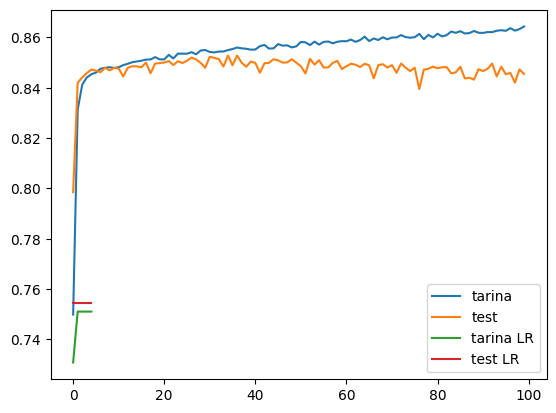

In [12]:
import matplotlib.pyplot as pl
plt.plot(history_sgd.history['accuracy'], label = "tarina")
plt.plot(history_sgd.history['val_accuracy'], label = "test")

plt.plot(history_lr_1.history['accuracy'], label = "tarina LR")
plt.plot(history_lr_1.history['val_accuracy'], label = "test LR")
plt.legend()
plt.show()

# Zad

Wykonaj analogiczne zadanie dla 
* Adam bez LearningRateScheduler i learning_rate=0.001
* Adam z użyciem LearningRateScheduler i learning_rate=0.001
* Adam z użyciem LearningRateScheduler i learning_rate=0.0001

Zwizualizuj wyniki:

* porównaj krzywe uczenia

# Adam

In [7]:
history_adam_001 = History()
model_adam_001 = Sequential(
    [
        Dense(100, activation="sigmoid", input_shape=(X_train.shape[1],)),
        Dense(50, activation="sigmoid"),
        Dense(10, activation="sigmoid"),
        Dense(1, activation="sigmoid"),
    ]
)

adam_001 = tf.keras.optimizers.Adam(learning_rate=0.001)
model_adam_001.compile(
    loss="binary_crossentropy", optimizer=adam_001, metrics=["accuracy"]
)
history_adam_001 = model_adam_001.fit(
    X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100
)

Epoch 1/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7903 - loss: 0.4500 - val_accuracy: 0.8421 - val_loss: 0.3436
Epoch 2/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8425 - loss: 0.3356 - val_accuracy: 0.8444 - val_loss: 0.3342
Epoch 3/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8498 - loss: 0.3273 - val_accuracy: 0.8461 - val_loss: 0.3290
Epoch 4/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8494 - loss: 0.3227 - val_accuracy: 0.8477 - val_loss: 0.3247
Epoch 5/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8501 - loss: 0.3180 - val_accuracy: 0.8493 - val_loss: 0.3234
Epoch 6/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8474 - loss: 0.3240 - val_accuracy: 0.8495 - val_loss: 0.3230
Epoch 7/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8510 - loss: 0.3208 - val_accuracy: 0.8409 - val_loss: 0.3328
Epoch 8/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8518 - loss: 0.3196 - val_accu

In [11]:
from keras.callbacks import LearningRateScheduler

history_adam_001_lr = History()
model_adam_001_lr = Sequential(
    [
        Dense(100, activation="sigmoid", input_shape=(X_train.shape[1],)),
        Dense(50, activation="sigmoid"),
        Dense(10, activation="sigmoid"),
        Dense(1, activation="sigmoid"),
    ]
)

adam_001_lr = tf.keras.optimizers.Adam(learning_rate=0.001)
model_adam_001_lr.compile(
    loss="binary_crossentropy", optimizer=adam_001_lr, metrics=["accuracy"]
)

lrate = LearningRateScheduler(step_decay)
history_adam_001_lr = model_adam_001_lr.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=100,
    callbacks=[lrate, history_adam_001_lr],
)

Epoch 1/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8226 - loss: 0.3802 - val_accuracy: 0.8476 - val_loss: 0.3316 - learning_rate: 0.0100
Epoch 2/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8441 - loss: 0.3297 - val_accuracy: 0.8452 - val_loss: 0.3338 - learning_rate: 0.0100
Epoch 3/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8524 - loss: 0.3183 - val_accuracy: 0.8503 - val_loss: 0.3238 - learning_rate: 0.0100
Epoch 4/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8479 - loss: 0.3193 - val_accuracy: 0.8492 - val_loss: 0.3200 - learning_rate: 0.0100
Epoch 5/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8560 - loss: 0.3100 - val_accuracy: 0.8493 - val_loss: 0.3252 - learning_rate: 0.0100
Epoch 6/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8548 - loss: 0.3100 - val_accuracy: 0.8486 - val_loss: 0.3207 - learning_rate: 0.0100
Epoch 7/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8583 - loss: 0.

In [12]:
history_adam_0001_lr = History()
model_adam_0001_lr = Sequential(
    [
        Dense(100, activation="sigmoid", input_shape=(X_train.shape[1],)),
        Dense(50, activation="sigmoid"),
        Dense(10, activation="sigmoid"),
        Dense(1, activation="sigmoid"),
    ]
)

adam_0001_lr = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_adam_0001_lr.compile(
    loss="binary_crossentropy", optimizer=adam_0001_lr, metrics=["accuracy"]
)

lrate = LearningRateScheduler(step_decay)
history_adam_0001_lr = model_adam_0001_lr.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=100,
    callbacks=[lrate, history_adam_0001_lr],
)

Epoch 1/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8108 - loss: 0.4029 - val_accuracy: 0.8456 - val_loss: 0.3348 - learning_rate: 0.0100
Epoch 2/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8511 - loss: 0.3233 - val_accuracy: 0.8487 - val_loss: 0.3244 - learning_rate: 0.0100
Epoch 3/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8524 - loss: 0.3166 - val_accuracy: 0.8455 - val_loss: 0.3259 - learning_rate: 0.0100
Epoch 4/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8532 - loss: 0.3142 - val_accuracy: 0.8500 - val_loss: 0.3232 - learning_rate: 0.0100
Epoch 5/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8549 - loss: 0.3105 - val_accuracy: 0.8479 - val_loss: 0.3199 - learning_rate: 0.0100
Epoch 6/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8607 - loss: 0.3030 - val_accuracy: 0.8505 - val_loss: 0.3190 - learning_rate: 0.0100
Epoch 7/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8571 - loss: 0.

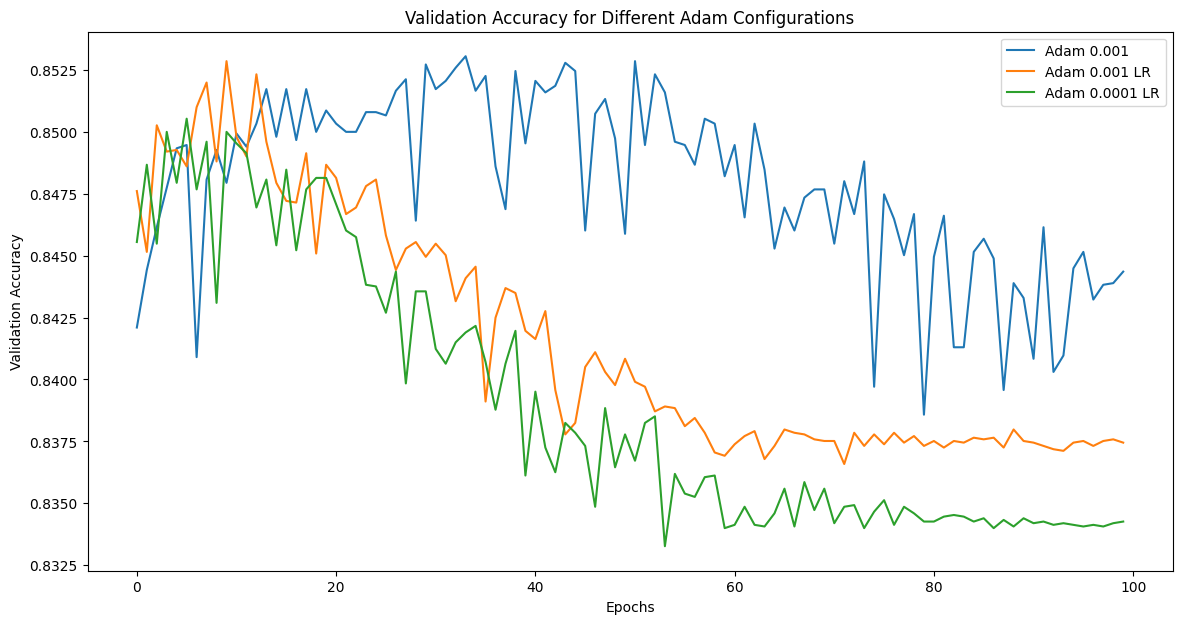

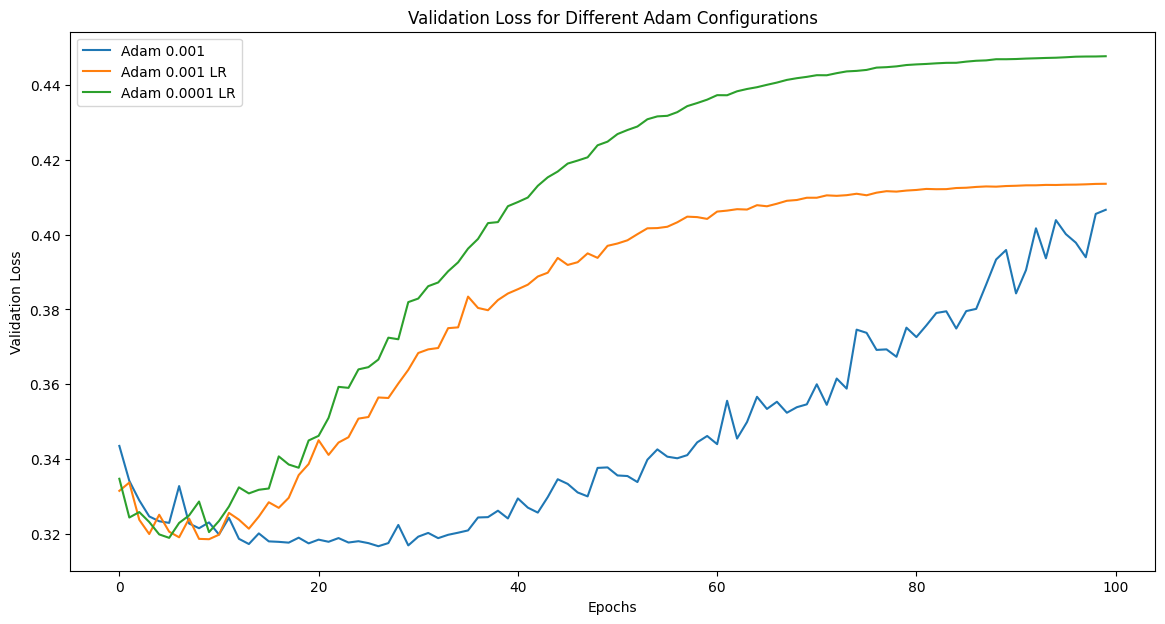

In [13]:
def plot_history(histories, title):
    plt.figure(figsize=(14, 7))
    for name, history in histories:
        plt.plot(history.history["val_accuracy"], label=name)
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.legend()
    plt.show()


histories = [
    ("Adam 0.001", history_adam_001),
    ("Adam 0.001 LR", history_adam_001_lr),
    ("Adam 0.0001 LR", history_adam_0001_lr),
]

plot_history(histories, "Validation Accuracy for Different Adam Configurations")


def plot_loss(histories, title):
    plt.figure(figsize=(14, 7))
    for name, history in histories:
        plt.plot(history.history["val_loss"], label=name)
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Validation Loss")
    plt.legend()
    plt.show()


plot_loss(histories, "Validation Loss for Different Adam Configurations")